# Screen cropping of digital and digit detection

This notebook intends to first find the screens on the images, to make easier the digit detection. To do so we also make a rotation based on the screen crops to make it horizontal.

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from google.colab.patches import cv2_imshow

Mounted at /content/drive


In [1]:
# Packages
import cv2
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
import math

**Updated**

In [2]:
# Function to Develop Cropped Images

def screen_crop_images(img_inp):
    '''
    Function to crop the screens
        
        img_inp -- array with the image pixel values
    
    Returns the cropped screen
    '''
  
    # Adjustment Parameters
    exposure = float(3)
    blur = 5
    erode, erosion_iterations = 4, 3
    dilate, dilate_iterations = 4, 3

    # Copy into file
    image = img_inp.copy()

    # Greyscale Image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Inversion of colors
    image = 255-image

    # Blur to reduce noise
    image = cv2.GaussianBlur(image, (blur, blur), 0)

    # Dilate
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (dilate, dilate))
    image = cv2.dilate(image, kernel, iterations=dilate_iterations)

    # Contour Generation
    ret, threshold = cv2.threshold(image, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _, contours, _ = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cv2.destroyAllWindows() 

    # Generate Cropped Image
    response = crop_to_screen_round1(img_inp,contours)

    return response


# Function to crop given the Contours Round 1
def crop_to_screen_round1(input_file,contour_boxed):
  
    lims = list()
    area_piece = list()
    area_ratio = list()
    dim_ratios = list()
    x_lists = list()
    y_lists = list()
    total_area_in_shape = float(input_file.shape[1]*input_file.shape[0])
    pos_threshold = 0.3
  
    for i in range(len(contour_boxed)):
        xdim = [x[0][0] for x in contour_boxed[i]]
        ydim = [x[0][1] for x in contour_boxed[i]]

        area_addit = (np.max(xdim)-np.min(xdim))*(np.max(ydim)-np.min(ydim))
        area_piece.append(area_addit)
        lims.append([min(xdim),min(ydim),max(xdim),max(ydim)])
        dim_ratios.append((max(xdim)-min(xdim))/(max(ydim)-min(ydim)))
        area_ratio.append(float(area_addit)/float(total_area_in_shape))
        x_lists.append(xdim)
        y_lists.append(ydim)

    restriction = pd.DataFrame()
    restriction['Areas'] = area_piece
    restriction['Ratio'] = area_ratio
    restriction['dim_ratio'] = dim_ratios
    restriction['xmax'] = [x[2] for x in lims]
    restriction['xmin'] = [x[0] for x in lims]
    restriction['ymax'] = [x[3] for x in lims]
    restriction['ymin'] = [x[1] for x in lims]

    restriction['xfull'] = x_lists
    restriction['yfull'] = y_lists

    restriction['xmean'] = (restriction['xmin']+restriction['xmax'])/2
    restriction['ymean'] = (restriction['ymin']+restriction['ymax'])/2

    restriction['x_pos_constr'] = restriction.xmean.apply(lambda x: 1 if (x>((0.5-pos_threshold)*input_file.shape[1]) and x<((0.5+pos_threshold)*input_file.shape[1])) else 0)
    restriction['y_pos_constr'] = restriction.ymean.apply(lambda x: 1 if (x>((0.5-pos_threshold)*input_file.shape[0]) and x<((0.5+pos_threshold)*input_file.shape[0])) else 0)


    area_piece_res = list(restriction[(restriction['Ratio']<0.97)&(restriction['dim_ratio']<4.5)&(restriction['dim_ratio']>1)&(restriction['x_pos_constr']==1)&(restriction['y_pos_constr']==1)].Areas)

    req_contour = area_piece.index(sorted(area_piece_res)[-1])

    lims_fin = lims[req_contour]


    cropped = input_file[lims_fin[1]:lims_fin[3],lims_fin[0]:lims_fin[2]]
  
  
  
    # Rotation
    res_temp = restriction.loc[req_contour]
    res_temp.yfull = [-x for x in res_temp.yfull]

    temp_df = pd.DataFrame()
    temp_df['x'] = res_temp.xfull
    temp_df['y'] = res_temp.yfull

    temp_df_u = temp_df.sort_values(by=['x','y'],ascending=[True,False]).drop_duplicates(subset=['x']).reset_index().drop('index',axis=1).rename(columns=({'y':'u_y'}))
    temp_df_d = temp_df.sort_values(by=['x','y'],ascending=[True,True]).drop_duplicates(subset=['x']).reset_index().drop('index',axis=1).rename(columns=({'y':'d_y'}))

    temp_max_x = temp_df[temp_df['x']==np.max(temp_df.x)]
    temp_min_x = temp_df[temp_df['x']==np.min(temp_df.x)]

    temp_max_y = temp_df[temp_df['y']==np.max(temp_df.y)]
    temp_min_y = temp_df[temp_df['y']==np.min(temp_df.y)]


    max_x_pt = np.mean(temp_max_x.x),np.mean(temp_max_x.y)
    min_x_pt = np.mean(temp_min_x.x),np.mean(temp_min_x.y)
    max_y_pt = np.mean(temp_max_y.x),np.mean(temp_max_y.y)
    min_y_pt = np.mean(temp_min_y.x),np.mean(temp_min_y.y)

    dist_list = list()

    angle = 0
    if (np.min(temp_df.x)==0 and (np.max(temp_min_x.y)-np.min(temp_min_x.y))>100) or (np.abs(np.max(temp_df.x)-input_file.shape[1])<2 and (np.max(temp_max_x.y)-np.min(temp_max_x.y))>100):
        angle = 0 #math.atan((np.max(temp_min_x.y)-np.max(temp_max_x.y))/(np.min(temp_min_x.x)-np.max(temp_max_x.x))+((np.min(temp_min_x.y)-np.min(temp_max_x.y))/(np.min(temp_min_x.x)-np.max(temp_max_x.x)))/2)

    else:                    
        if distance_between(max_x_pt,min_y_pt)<100:
            max_x_pt=min_y_pt
        if distance_between(max_x_pt,max_y_pt)<100:
            max_x_pt=max_y_pt
        if distance_between(min_x_pt,min_y_pt)<100:
            min_x_pt=min_y_pt  
        if distance_between(min_x_pt,max_y_pt)<100:
            min_x_pt=max_y_pt

        pt_list = list((max_x_pt, min_x_pt, max_y_pt, min_y_pt))
    
    if len(list(dict.fromkeys(pt_list)))==4:
        sec_min_y = min_x_pt if min_x_pt[1]<max_x_pt[1] else max_x_pt
        sec_max_y = min_x_pt if min_x_pt[1]>max_x_pt[1] else max_x_pt
        angle = math.atan((((min_y_pt[1]-sec_min_y[1])/(min_y_pt[0]-sec_min_y[0]))+((max_y_pt[1]-sec_max_y[1])/(max_y_pt[0]-sec_max_y[0])))/2)

    h = cropped.shape[0]
    w = cropped.shape[1]

    center = (round(w/2),round(h/2))
    M = cv2.getRotationMatrix2D(center, -angle*180/math.pi, 1)
    rotated = cv2.warpAffine(cropped, M, (w, h))

    if np.abs(-angle*180/math.pi)<5:
        response = rotated
    else:
        response = screen_crop_images_round2(rotated)
    return response


# Function to Develop Cropped Images Round 2
def screen_crop_images_round2(img_inp):
  
    # Adjustment Parameters
    exposure = float(3)
    blur = 5
    erode, erosion_iterations = 4, 3
    dilate, dilate_iterations = 4, 3

    # Copy into file
    image = img_inp

    # Blur to reduce noise
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.GaussianBlur(image, (blur, blur), 0)

    # Dilate
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (dilate, dilate))
    image = cv2.dilate(image, kernel, iterations=dilate_iterations)

    # Contour Generation
    ret, threshold = cv2.threshold(image, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _, contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cv2.destroyAllWindows() 

    # Generate Cropped Image
    response = crop_to_screen_round2(img_inp,contours)

    return response






# Function to crop given the Contours

def crop_to_screen_round2(input_file,contour_boxed):
  
    lims = list()
    area_piece = list()
    area_ratio = list()
    dim_ratios = list()
    total_area_in_shape = float(input_file.shape[1]*input_file.shape[0])
    pos_threshold = 0.3

    for i in range(len(contour_boxed)):
        xdim = [x[0][0] for x in contour_boxed[i]]
        ydim = [x[0][1] for x in contour_boxed[i]]

        area_addit = (np.max(xdim)-np.min(xdim))*(np.max(ydim)-np.min(ydim))
        area_piece.append(area_addit)
        lims.append([min(xdim),min(ydim),max(xdim),max(ydim)])
        dim_ratios.append((max(xdim)-min(xdim))/(max(ydim)-min(ydim)))
        area_ratio.append(float(area_addit)/float(total_area_in_shape))

    restriction = pd.DataFrame()
    restriction['Areas'] = area_piece
    restriction['Ratio'] = area_ratio
    restriction['dim_ratio'] = dim_ratios
    restriction['xmax'] = [x[2] for x in lims]
    restriction['xmin'] = [x[0] for x in lims]
    restriction['ymax'] = [x[3] for x in lims]
    restriction['ymin'] = [x[1] for x in lims]

    restriction['xmean'] = (restriction['xmin']+restriction['xmax'])/2
    restriction['ymean'] = (restriction['ymin']+restriction['ymax'])/2

    restriction['x_pos_constr'] = restriction.xmean.apply(lambda x: 1 if (x>((0.5-pos_threshold)*input_file.shape[1]) and x<((0.5+pos_threshold)*input_file.shape[1])) else 0)
    restriction['y_pos_constr'] = restriction.ymean.apply(lambda x: 1 if (x>((0.5-pos_threshold)*input_file.shape[0]) and x<((0.5+pos_threshold)*input_file.shape[0])) else 0)


    area_piece_res = list(restriction[(restriction['Ratio']<0.999)&(restriction['dim_ratio']<4.5)&(restriction['dim_ratio']>1)&(restriction['x_pos_constr']==1)&(restriction['y_pos_constr']==1)].Areas)

    try:
        req_contour = area_piece.index(sorted(area_piece_res)[-1])
    except:
        req_contour = area_piece.index(sorted(area_piece_res)[0])

    lims_fin = lims[req_contour]
    
    return input_file[lims_fin[1]:lims_fin[3],lims_fin[0]:lims_fin[2]]

In [116]:
tempcounter = 0
total_files = len(os.listdir(repo))

for files in os.listdir(repo):
    if '.jpg' in files:
        tempcounter=tempcounter+1
    if tempcounter%10==0:
          print(str(round(100*tempcounter/total_files,2))+'%')
    image = cv2.imread(repo+files)

    output = screen_crop_images(image)
    Image.fromarray(output).save(outs+files[:-4]+'_cropped.jpg')


# for files in os.listdir(repm):
#   if '.jpg' in files:
#     tempcounter=tempcounter+1
#     if tempcounter%10==0:
#       print(str(round(100*tempcounter/total_files,2))+'%')
#     image = cv2.imread(repm+files)
#     output = greyscaled_images(image)
#     Image.fromarray(output).save(grem+files[:-4]+'_cropped.jpg')


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


4.5%
9.01%
13.51%
18.02%
22.52%
27.03%
31.53%
36.04%
40.54%
45.05%
49.55%
54.05%
58.56%
63.06%
67.57%
72.07%
76.58%
81.08%
85.59%
90.09%
94.59%


In [0]:
os.listdir('/content/drive/My Drive/Team Bergere/Optimizer/Data/optimizer/LQ_digital/Greyscaled/')

[]

In [0]:
tempcounter

218

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


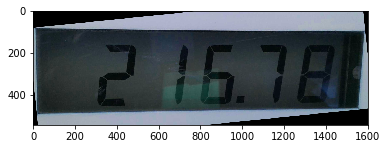

In [119]:
img_inp = cv2.imread(repo+'8e4f016190f77e5aa58c53509d869e915a0be67b.jpg')
output = screen_crop_images(img_inp)

imshow(output)


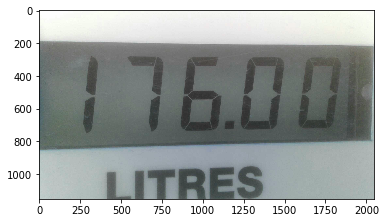

In [42]:
imshow(img_inp)

**Testing**

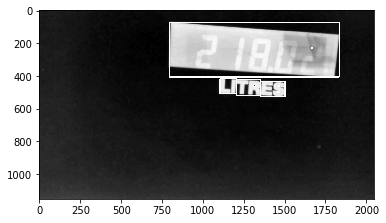

In [17]:
path = 'Dataset/HQ_digital/cd4d249fd27369f927124e67151b8d97e4bdfdd4.jpg'
img_inp = cv2.imread(path)
# img_inp = cv2.imread(repm+'0efee8cda30576dd21221732f6c20dec74e3bbd9.jpg')


# Adjustment Parameters
exposure = float(3)
blur = 5
erode, erosion_iterations = 4, 3
dilate, dilate_iterations = 4, 3

# Copy into file
image = img_inp

# Greyscale Image
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = 255-image

# Blur to reduce noise
image = cv2.GaussianBlur(image, (blur, blur), 0)

# Dilate
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (dilate, dilate))
image = cv2.dilate(image, kernel, iterations=dilate_iterations)


# Contour Generation
ret, threshold = cv2.threshold(image, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
contours, _ = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
cv2.destroyAllWindows() 

input_file = image
contour_boxed = contours

lims = list()
area_piece = list()
area_ratio = list()
dim_ratios = list()
x_lists = list()
y_lists = list()
total_area_in_shape = float(input_file.shape[1]*input_file.shape[0])
pos_threshold = 0.3

for i in range(len(contour_boxed)):

    xdim = [x[0][0] for x in contour_boxed[i]]
    ydim = [x[0][1] for x in contour_boxed[i]]

    area_addit = (np.max(xdim)-np.min(xdim))*(np.max(ydim)-np.min(ydim))
    area_piece.append(area_addit)
    x_lists.append(xdim)
    y_lists.append(ydim)
    lims.append([min(xdim),min(ydim),max(xdim),max(ydim)])
    dim_ratios.append((max(xdim)-min(xdim))/(max(ydim)-min(ydim)))
    area_ratio.append(float(area_addit)/float(total_area_in_shape))

restriction = pd.DataFrame()
restriction['Areas'] = area_piece
restriction['Ratio'] = area_ratio
restriction['dim_ratio'] = dim_ratios
restriction['xmax'] = [x[2] for x in lims]
restriction['xmin'] = [x[0] for x in lims]
restriction['ymax'] = [x[3] for x in lims]
restriction['ymin'] = [x[1] for x in lims]
restriction['xfull'] = x_lists
restriction['yfull'] = y_lists
restriction['contour'] = contour_boxed

restriction['xmean'] = (restriction['xmin']+restriction['xmax'])/2
restriction['ymean'] = (restriction['ymin']+restriction['ymax'])/2

restriction['x_pos_constr'] = restriction.xmean.apply(lambda x: 1 if (x>((0.5-pos_threshold)*input_file.shape[1]) and x<((0.5+pos_threshold)*input_file.shape[1])) else 0)
restriction['y_pos_constr'] = restriction.ymean.apply(lambda x: 1 if (x>((0.5-pos_threshold)*input_file.shape[0]) and x<((0.5+pos_threshold)*input_file.shape[0])) else 0)

#print(restriction)
area_piece_res = list(restriction[(restriction['Ratio']<0.97)&(restriction['dim_ratio']<4.5)&(restriction['dim_ratio']>1)&(restriction['x_pos_constr']==1)&(restriction['y_pos_constr']==1)].Areas)
resresres = restriction[(restriction['Ratio']<0.97)&(restriction['dim_ratio']<4.5)&(restriction['dim_ratio']>1)&(restriction['x_pos_constr']==1)&(restriction['y_pos_constr']==1)]
#print(sorted(area_piece_res))
req_contour = area_piece.index(sorted(area_piece_res)[-1])

lims_fin = lims[req_contour]

#imshow(input_file[lims_fin[1]:lims_fin[3],lims_fin[0]:lims_fin[2]])

In [15]:
input_file.shape

(1152, 2048)

In [0]:
cc = restriction.loc[req_contour].contour

cropped = input_file[lims_fin[1]:lims_fin[3],lims_fin[0]:lims_fin[2]]



/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


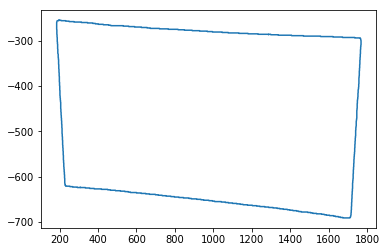

In [101]:
res_temp = restriction.loc[req_contour]
res_temp.yfull = [-x for x in res_temp.yfull]
plt.plot(res_temp.xfull,res_temp.yfull)

plt.show()

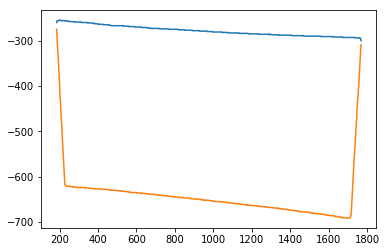

In [102]:
temp_df = pd.DataFrame()
temp_df['x'] = res_temp.xfull
temp_df['y'] = res_temp.yfull

temp_df_u = temp_df.sort_values(by=['x','y'],ascending=[True,False]).drop_duplicates(subset=['x']).reset_index().drop('index',axis=1).rename(columns=({'y':'u_y'}))
temp_df_d = temp_df.sort_values(by=['x','y'],ascending=[True,True]).drop_duplicates(subset=['x']).reset_index().drop('index',axis=1).rename(columns=({'y':'d_y'}))

plt.plot(temp_df_u.x,temp_df_u.u_y)
plt.plot(temp_df_d.x,temp_df_d.d_y)
plt.show()


[(1768.0, -304.5), (202.0, -255.0), (202.0, -255.0), (1691.5, -691.0)]


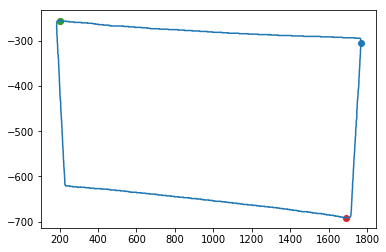

(1768, 2048)

In [106]:
temp_max_x = temp_df[temp_df['x']==np.max(temp_df.x)]
temp_min_x = temp_df[temp_df['x']==np.min(temp_df.x)]

temp_max_y = temp_df[temp_df['y']==np.max(temp_df.y)]
temp_min_y = temp_df[temp_df['y']==np.min(temp_df.y)]


max_x_pt = np.mean(temp_max_x.x),np.mean(temp_max_x.y)
min_x_pt = np.mean(temp_min_x.x),np.mean(temp_min_x.y)
max_y_pt = np.mean(temp_max_y.x),np.mean(temp_max_y.y)
min_y_pt = np.mean(temp_min_y.x),np.mean(temp_min_y.y)

def distance_between(pt1,pt2):
    return np.sqrt(((pt1[0]-pt2[0])**2)+((pt1[1]-pt2[1])**2))

angle = 0
if (np.min(temp_df.x)==0 and (np.max(temp_min_x.y)-np.min(temp_min_x.y))>100) or (np.abs(np.max(temp_df.x)-input_file.shape[1])<2 and (np.max(temp_max_x.y)-np.min(temp_max_x.y))>100):
    print('hi')
    angle = 0 #math.atan((np.max(temp_min_x.y)-np.max(temp_max_x.y))/(np.min(temp_min_x.x)-np.max(temp_max_x.x))+((np.min(temp_min_x.y)-np.min(temp_max_x.y))/(np.min(temp_min_x.x)-np.max(temp_max_x.x)))/2)

else:                    
    if distance_between(max_x_pt,min_y_pt)<100:
        max_x_pt=min_y_pt
    if distance_between(max_x_pt,max_y_pt)<100:
        max_x_pt=max_y_pt
    if distance_between(min_x_pt,min_y_pt)<100:
        min_x_pt=min_y_pt  
    if distance_between(min_x_pt,max_y_pt)<100:
        min_x_pt=max_y_pt

    pt_list = list((max_x_pt, min_x_pt, max_y_pt, min_y_pt))                    

    if len(list(dict.fromkeys(pt_list)))==4:
        sec_min_y = min_x_pt if min_x_pt[1]<max_x_pt[1] else max_x_pt
        sec_max_y = min_x_pt if min_x_pt[1]>max_x_pt[1] else max_x_pt
        angle = math.atan((((min_y_pt[1]-sec_min_y[1])/(min_y_pt[0]-sec_min_y[0]))+((max_y_pt[1]-sec_max_y[1])/(max_y_pt[0]-sec_max_y[0])))/2)


print(pt_list)
# max_x_pt, min_x_pt, max_y_pt, min_y_pt

plt.scatter(max_x_pt[0],max_x_pt[1])
plt.scatter(min_x_pt[0],min_x_pt[1])
plt.scatter(max_y_pt[0],max_y_pt[1])
plt.scatter(min_y_pt[0],min_y_pt[1])


plt.plot(res_temp.xfull,res_temp.yfull)
plt.show()
np.max(temp_df.x),input_file.shape[1]
  

In [91]:
  angle*180/math.pi

0.0

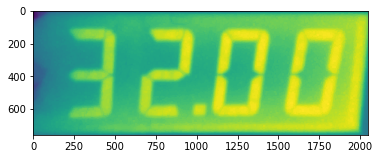

In [92]:
# temppp = imutils.rotate_bound(cropped,-angle)
h = cropped.shape[0]
w = cropped.shape[1]

center = (round(w/2),round(h/2))
M = cv2.getRotationMatrix2D(center, angle*180/math.pi, 1)
rotated = cv2.warpAffine(cropped, M, (w, h))
imshow(rotated)

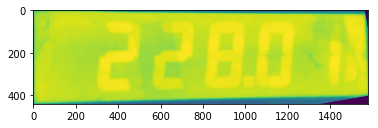

In [0]:
# Adjustment Parameters
exposure = float(3)
blur = 5
erode, erosion_iterations = 4, 3
dilate, dilate_iterations = 4, 3

# Copy into file
image = rotated

# Greyscale Image
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = 255-image

# Blur to reduce noise
image = cv2.GaussianBlur(image, (blur, blur), 0)

# Dilate
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (dilate, dilate))
image = cv2.dilate(image, kernel, iterations=dilate_iterations)

# Contour Generation
ret, threshold = cv2.threshold(image, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
_, contours, _ = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
cv2.destroyAllWindows() 



input_file = image
contour_boxed = contours

lims = list()
area_piece = list()
area_ratio = list()
dim_ratios = list()
x_lists = list()
y_lists = list()
total_area_in_shape = float(input_file.shape[1]*input_file.shape[0])
pos_threshold = 0.3

for i in range(len(contour_boxed)):

    xdim = [x[0][0] for x in contour_boxed[i]]
    ydim = [x[0][1] for x in contour_boxed[i]]

    area_addit = (np.max(xdim)-np.min(xdim))*(np.max(ydim)-np.min(ydim))
    area_piece.append(area_addit)
    x_lists.append(xdim)
    y_lists.append(ydim)
    lims.append([min(xdim),min(ydim),max(xdim),max(ydim)])
    dim_ratios.append((max(xdim)-min(xdim))/(max(ydim)-min(ydim)))
    area_ratio.append(float(area_addit)/float(total_area_in_shape))

restriction = pd.DataFrame()
restriction['Areas'] = area_piece
restriction['Ratio'] = area_ratio
restriction['dim_ratio'] = dim_ratios
restriction['xmax'] = [x[2] for x in lims]
restriction['xmin'] = [x[0] for x in lims]
restriction['ymax'] = [x[3] for x in lims]
restriction['ymin'] = [x[1] for x in lims]
restriction['xfull'] = x_lists
restriction['yfull'] = y_lists
restriction['contour'] = contour_boxed

restriction['xmean'] = (restriction['xmin']+restriction['xmax'])/2
restriction['ymean'] = (restriction['ymin']+restriction['ymax'])/2

restriction['x_pos_constr'] = restriction.xmean.apply(lambda x: 1 if (x>((0.5-pos_threshold)*input_file.shape[1]) and x<((0.5+pos_threshold)*input_file.shape[1])) else 0)
restriction['y_pos_constr'] = restriction.ymean.apply(lambda x: 1 if (x>((0.5-pos_threshold)*input_file.shape[0]) and x<((0.5+pos_threshold)*input_file.shape[0])) else 0)


area_piece_res = list(restriction[(restriction['Ratio']<0.97)&(restriction['dim_ratio']<4.5)&(restriction['dim_ratio']>1)&(restriction['x_pos_constr']==1)&(restriction['y_pos_constr']==1)].Areas)
resresres = restriction[(restriction['Ratio']<0.97)&(restriction['dim_ratio']<4.5)&(restriction['dim_ratio']>1)&(restriction['x_pos_constr']==1)&(restriction['y_pos_constr']==1)]
req_contour = area_piece.index(sorted(area_piece_res)[-1])

lims_fin = lims[req_contour]

imshow(input_file[lims_fin[1]:lims_fin[3],lims_fin[0]:lims_fin[2]])

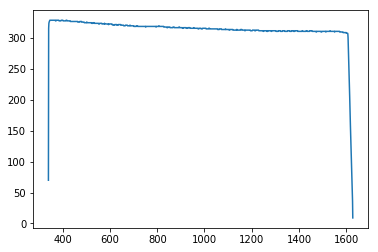

In [0]:
# upper_chg = list()

# for i in range(1,len(temp_df_u)):
#   upper_chg.append(temp_df_u.y.loc[i]-temp_df_u.y.loc[i-1])

comb = pd.merge(temp_df_u,temp_df_d,on='x')
comb['diffh'] = comb.u_y - comb.d_y
  
plt.plot(comb.x,comb.diffh)
plt.show()


In [0]:
upper_chg = list()

for i in range(1,len(temp_df_u)):
  upper_chg.append(temp_df_u.y.loc[i]-temp_df_u.y.loc[i-1])

,index,x,y
0,325,339,597
1,327,340,599
2,328,341,599
3,329,342,600
4,330,343,600
5,331,344,600
6,332,345,601
7,333,346,601
8,334,347,601
9,335,348,601


# Processing, post screen cropping

After cropping the screen and rotating, we have tried to find the contours of the digits. However, due to the low contrast of the numbers and the gray background, we did not reach to any interesting result. We present below the methods tried in any case.

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
# Support functions
def addContrast(image):
    '''
    Function to add contrast to the image, since many are very dark.
        image -- array of image pixel values
    Returns input image with greater contrast
    '''
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl,a,b))

    #-----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

def exposure_to_bright(file_in):
    image = cv2.imread(file_in)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    h1,w1 = image.shape
    h1 = round(h1/2)
    w1 = round(w1/2)

    i = 5
    flag = 0
    while ((i<101) and (flag==0)):
        exp = i/10
        image_t = cv2.multiply(image, np.array([exp]))

        out_mean = np.mean(image_t[h1-100:h1+100,w1-100:w1+100])

        if ((out_mean<125) and (out_mean>115)):
            flag = 1
        i = i+1

    return exp,np.mean(image[h1-100:h1+100,w1-100:w1+100])

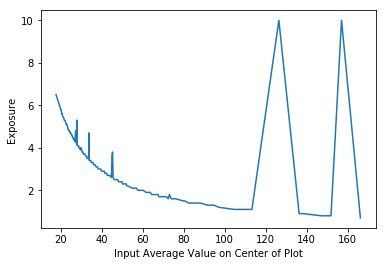

In [4]:
exposurein = list()
inp_bright = list()

data = 'Dataset/'
for f in os.listdir(data+'Cropped_Upd/'):
        a,b = exposure_to_bright(data+'Cropped_Upd/'+f)
        exposurein.append(a)
        inp_bright.append(b)
        
# Plot of Exposure vs Brightness
exposure_df = pd.DataFrame()
exposure_df['exp'] = exposurein
exposure_df['inp'] = inp_bright

# exposure_df = exposure_df.groupby('inp').agg({'exposurein':'mean'}).reset_index()
exposure_df = exposure_df.sort_values(by=['inp','exp'])

plt.plot(exposure_df.inp,exposure_df.exp)
plt.ylabel('Exposure')
plt.xlabel('Input Average Value on Center of Plot')
plt.show()

[-1.46142540e-03  1.13148326e+02]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


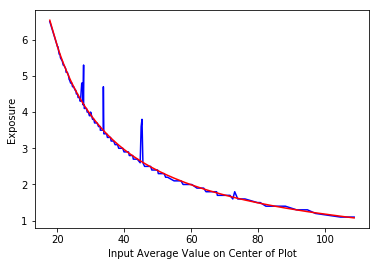

In [5]:
lm = LinearRegression()
# retaining only till 110

exposure_df_ret = exposure_df[exposure_df['inp']<110]

exposure_df_ret['inp_inv'] = 1/exposure_df['inp']

x = exposure_df_ret[['inp','inp_inv']].values
y = exposure_df_ret['exp'].values

lm.fit(x,y)

preds = lm.predict(x)

print(lm.coef_)

plt.plot(exposure_df_ret.inp,exposure_df_ret.exp, color='blue', label='Data')
plt.plot(exposure_df_ret.inp,preds, color='red', label='Predicted')
plt.ylabel('Exposure')
plt.xlabel('Input Average Value on Center of Plot')
plt.show()

Based on the regression shown above, the optimum exposure factor seem to be given by:

$$
    exposure = ax + \frac{b}{x}
$$

Where $a = -1.46142540e^{-3}$ and $1.13148326e^{2}$

Then, we can adjust the exposure of the image to improve it.

In [13]:
def extract_numbers(image): 
    '''
    Function to find the contours of digits
        image -- array with image pixel values
    Shows the original image with the contours found
    '''
    original = image.copy()
    sh = image.shape
    # Removing some borders since typically the border of the screens are really dark
    perc = 0.01
    image = image[int(sh[0]*perc):int(sh[0]*(1-perc)), int(sh[1]*perc):int(sh[1]*(1-perc))]
    
    # -----------Adjust Exposure--------
    # Exposure follows ax+b(1/x) formulation with params
    exposure_params = [-1.46142540e-03, 1.13148326e+02]
    # Dimensions
    h1,w1 = sh[0], sh[1]
    h1 = round(h1/2)
    w1 = round(w1/2)
    center_mean = np.mean(image[h1-100:h1+100,w1-100:w1+100])
    exposure = (exposure_params[0]*center_mean) + (exposure_params[1]/center_mean)

    image = cv2.multiply(image, np.array([exposure]))
    #imshow(image, cmap= "gray")
    
    #-----------Add Contrast------------
    
    image = addContrast(image)

    # --------------Convert to Greyscale -----------
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #imshow(image, cmap= "gray")
    
    # Adaptive Thresholding
    ad_threshold = 71
    ad_adjustment = 13
    image = cv2.adaptiveThreshold(image, 255, 
                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,ad_threshold, ad_adjustment)
    #imshow(image, cmap= "gray")
    
    #----------BilateralFilter-----------
    diam = 10
    size = 80
    image = cv2.bilateralFilter ( image,diam , size, size )
    
    # ----------MORPHOLOGICAL TRANSFORM: Closing-------------
    close = 5
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (close, close))
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    #imshow(image, cmap= "gray")
    
    # -------------------Erosion-----------------
    erode, er_it = 3,2
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (erode, erode))
    image = cv2.erode(image, kernel, iterations=er_it)
    #imshow(image, cmap= "gray")
    
    def inverse_colors(img):
        img = (255 - img)
        return img

    # Reverse the image color
    #image = inverse_colors(image)
    #imshow(image, cmap= "gray")

    # Finding Contours
    contours,_= cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    for contour in contours:
        [x, y, w, h] = cv2.boundingRect(contour)
        if w*h > 800:
            original = cv2.rectangle(original, 
                    (int(x-0.01*w), int(y-h*0.01)), (int(x + 1.01*w), int(y + 1.01*h)), (0, 255, 0), 4)
    imshow(original, cmap= "gray")
    write_path = 'Dataset/PPT'
    cv2.imwrite(os.path.join(write_path , 'alternative.jpg'), original)
    

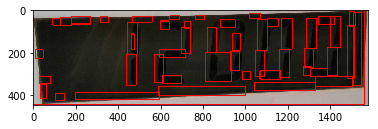

In [7]:
filename1 = 'Dataset/Cropped_Upd/0086c28630535f9d722eed740f9ce3f8336ec432_cropped.jpg'
image = cv2.imread(filename1)
extract_numbers(image)

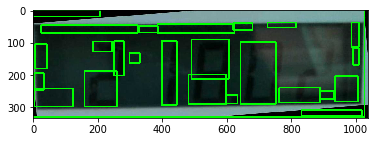

In [14]:

filename1 = 'Dataset/HQ_digital_processed/cd4d249fd27369f927124e67151b8d97e4bdfdd4_cropped.jpg'
image = cv2.imread(filename1)
extract_numbers(image)